# Exploratory analysis

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns


import plotly.express as px

In [2]:
import sys
sys.path.append('../')

from EnefitModels.src.features import load_data

data = load_data.load_processed_data('../data')

## Questions and Ideas while working:

1. What are the time zones of the different datasets? The weather forecasts explicitly specify a timezone.
2. Outliers in electricity prices: there are some extreme spikes.


### Initial set of regressors
- gas and electricity prices
- eic and installed capacity for points in the client set.

### Explaination for the missing data points in the electricity markets
Are these DST transitions?


## Price data

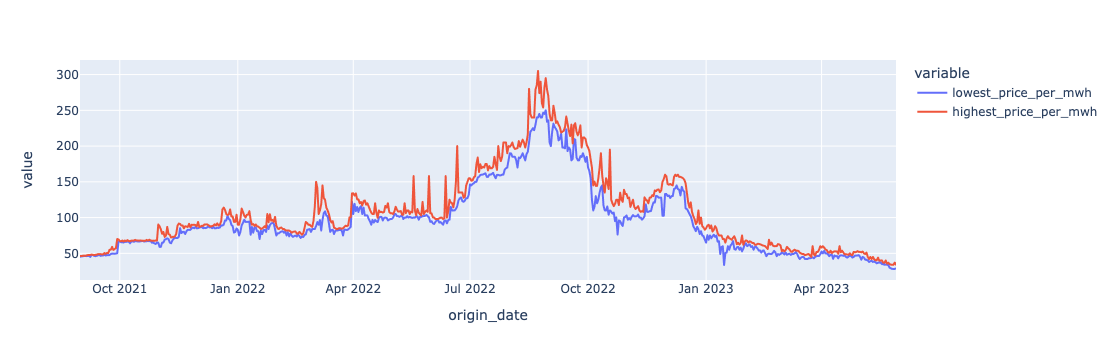

In [4]:
px.line(data.gasPrices, x='origin_date', y=['lowest_price_per_mwh', 'highest_price_per_mwh'])

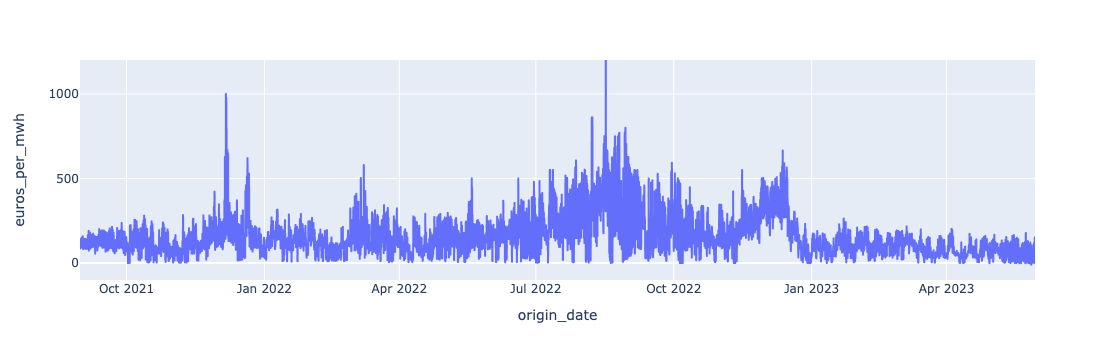

In [6]:
fig = px.line(data.electricityPrices, x='origin_date', y='euros_per_mwh')
fig.update_yaxes(range=[-100, 1200])
fig.show()

<AxesSubplot:title={'center':'Daily electricity prices: mean std dev'}, xlabel='origin_hour', ylabel='euros_per_mwh'>

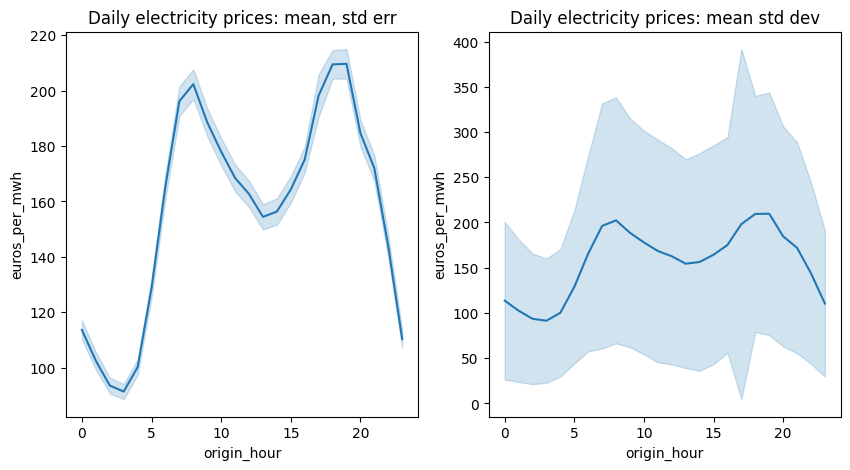

In [8]:
hours = data.electricityPrices.origin_date.dt.hour
hours.name = 'origin_hour'

figsize(10, 5)
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.title('Daily electricity prices: mean, std err')
sns.lineplot(data=pd.concat([data.electricityPrices, hours],axis=1), x='origin_hour', y='euros_per_mwh', errorbar='se')

plt.subplot(1,2,2)
plt.title('Daily electricity prices: mean std dev')
sns.lineplot(data=pd.concat([data.electricityPrices, hours],axis=1), x='origin_hour', y='euros_per_mwh', errorbar='sd')



This is the time-dependence of price with time of day. 
1. The dependence looks reasonable
2. The mean effect is well estimated, even though it is swamped by variance from other factors.

A better way to measure this is the daily time dependence around daily average.

In [16]:
gasMean = (data.gasPrices.set_index('origin_date').lowest_price_per_mwh +
           data.gasPrices.set_index('origin_date').highest_price_per_mwh )/2
gasMean.name = 'gasMean'

gasDiff = (data.gasPrices.set_index('origin_date').highest_price_per_mwh -
           data.gasPrices.set_index('origin_date').lowest_price_per_mwh)
gasDiff.name = 'gasRange'

days = data.electricityPrices.origin_date.dt.date
electricData = data.electricityPrices.groupby(days).agg(electricMean=('euros_per_mwh', 'mean'),
                                                       electricRange=('euros_per_mwh', np.ptp) )

priceComp = pd.concat([electricData, gasMean, gasDiff], axis=1)

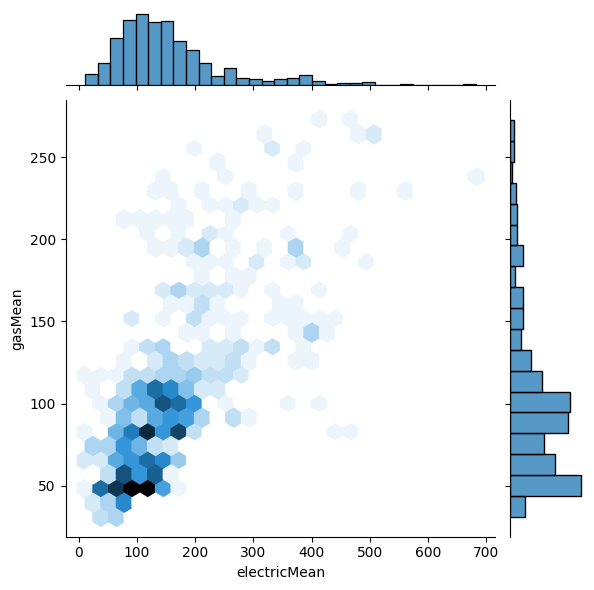

In [54]:
fig = sns.jointplot(data=priceComp, x='electricMean', y='gasMean', kind='hex')
fig.fig.suptitle = 'Daily average electricity and gas prices'

(0.0, 100.0)

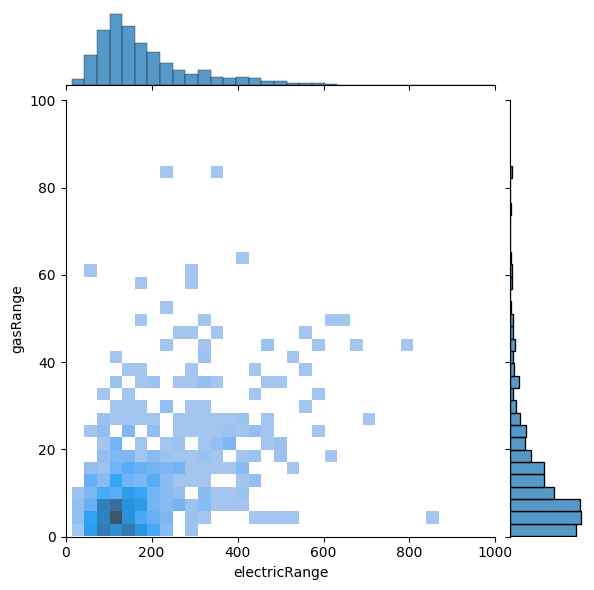

In [52]:
fig = sns.jointplot(data=priceComp, x='electricRange', y='gasRange', kind='hist')
plt.xlim(0, 1000)
plt.ylim(0, 100)

The mean daily prices of electricity and gas are nicely correlated. There is less clear connection between the volatility of gas and electrical prices daily. However, the volatility of electricity is much higher.

## Clients and Training

### Clients

In [3]:
data.clients.head()

product_type  county  eic_count  installed_capacity  is_business  \
0             1       0        108              952.89            0   
1             2       0         17              166.40            0   
2             3       0        688             7207.88            0   
3             0       0          5              400.00            1   
4             1       0         43             1411.00            1   

         date  data_block_id  
0  2021-09-01              2  
1  2021-09-01              2  
2  2021-09-01              2  
3  2021-09-01              2  
4  2021-09-01              2

<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

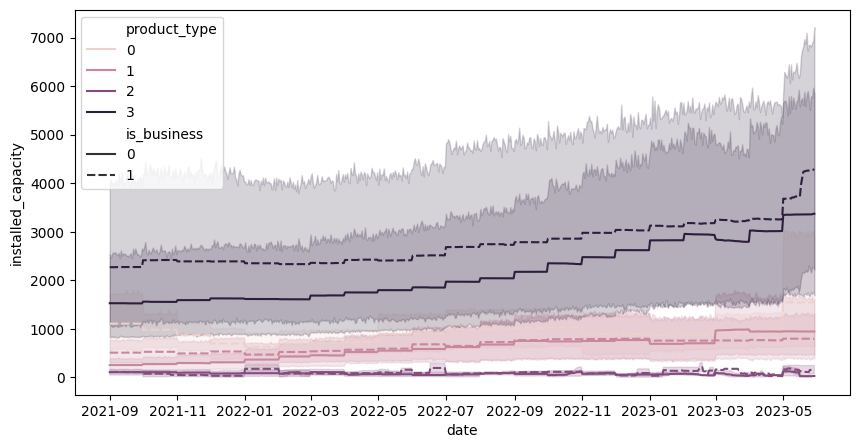

In [71]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='product_type', style='is_business')

<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

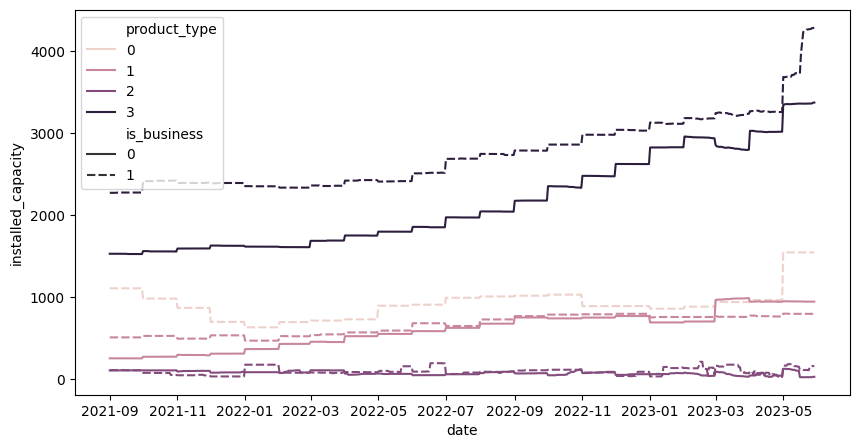

In [69]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='product_type', style='is_business', errorbar=None)

Most of the capacity is in product type 3 and for buisnesses. Product 0 appears to be available to buisnesses only.

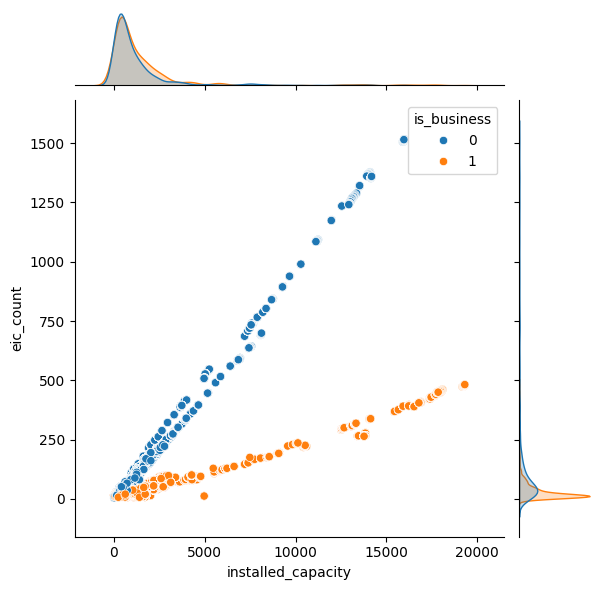

In [76]:
sns.jointplot(data=data.clients, x='installed_capacity', y='eic_count', hue='is_business')

At the very large capacities / eic counts, they correlate very well, with a slope that depends on whether the location is a buisness. However, this represents a very small fraction of the data.

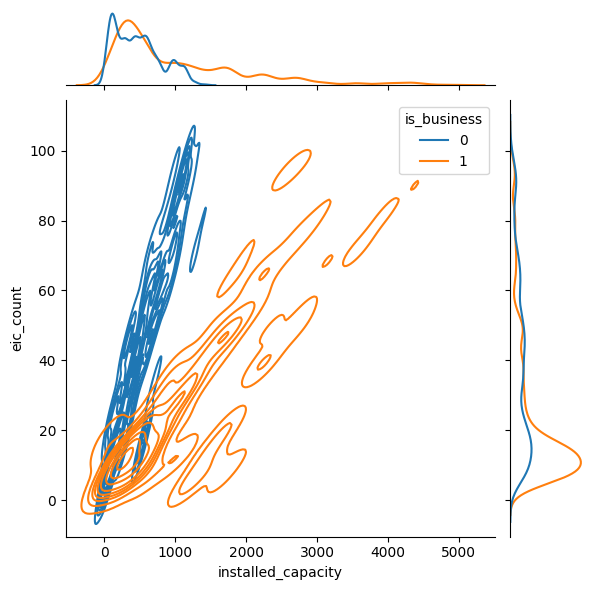

In [97]:
sns.jointplot(data=data.clients[ (data.clients.eic_count < 100) ],
              x='installed_capacity', y='eic_count', hue='is_business', kind='kde')

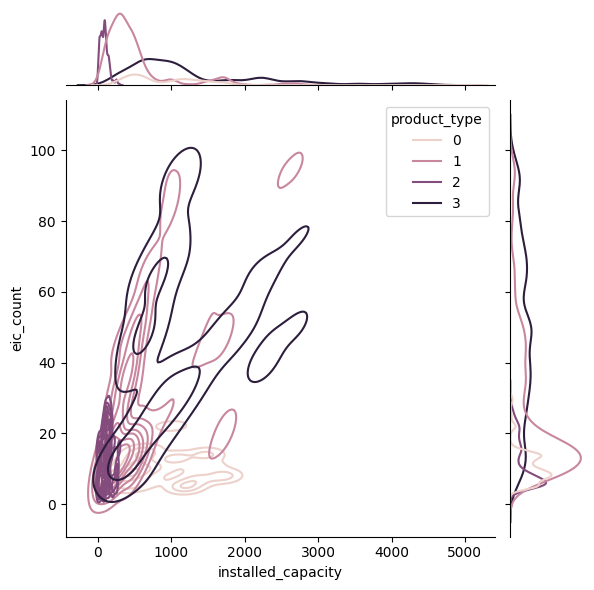

In [95]:
sns.jointplot(data=data.clients[ (data.clients.eic_count < 100) ],
              x='installed_capacity', y='eic_count', hue='product_type', kind='kde')

This relationship seems to hold down into the bulk of the data, and  can resolve product types as well.

<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

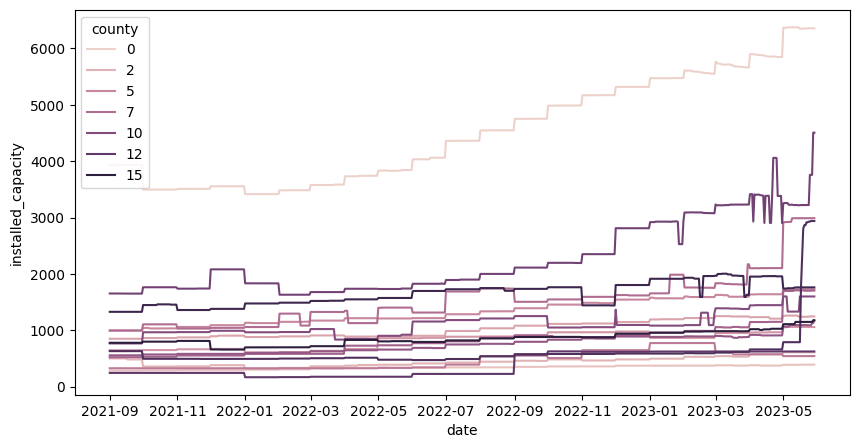

In [139]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='county', errorbar=None)

Hard to read much out of the county level data. Except that we know that one county dominates the others.

### Training

In [6]:
data.train.describe()

county   is_business  product_type        target  is_consumption  \
count  2.018352e+06  2.018352e+06  2.018352e+06  2.017824e+06       2018352.0   
mean   7.297034e+00  5.368261e-01  1.898927e+00  2.748556e+02             0.5   
std    4.780990e+00  4.986421e-01  1.081766e+00  9.095024e+02             0.5   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             0.0   
25%    3.000000e+00  0.000000e+00  1.000000e+00  3.780000e-01             0.0   
50%    7.000000e+00  1.000000e+00  2.000000e+00  3.113300e+01             0.5   
75%    1.100000e+01  1.000000e+00  3.000000e+00  1.802062e+02             1.0   
max    1.500000e+01  1.000000e+00  3.000000e+00  1.548027e+04             1.0   

       data_block_id        row_id  prediction_unit_id  
count   2.018352e+06  2.018352e+06        2.018352e+06  
mean    3.218746e+02  1.009176e+06        3.304538e+01  
std     1.826343e+02  5.826482e+05        1.959059e+01  
min     0.000000e+00  0.000000e+00        0.000000e+00  
25%     1.660000e+02  5.045878e+05        1.600000e+01  
50%     3.230000e+02  1.009176e+06        3.300000e+01  
75%     4.790000e+02  1.513763e+06        5.000000e+01  
max     6.370000e+02  2.018351e+06        6.800000e+01

In [9]:
data.train.head()

county  is_business  product_type  target  is_consumption  \
0       0            0             1   0.713               0   
1       0            0             1  96.590               1   
2       0            0             2   0.000               0   
3       0            0             2  17.314               1   
4       0            0             3   2.904               0   

                   datetime  data_block_id  row_id  prediction_unit_id  
0 2021-08-31 22:00:00+00:00              0       0                   0  
1 2021-08-31 22:00:00+00:00              0       1                   0  
2 2021-08-31 22:00:00+00:00              0       2                   1  
3 2021-08-31 22:00:00+00:00              0       3                   1  
4 2021-08-31 22:00:00+00:00              0       4                   2

I'm curious about seasonality in the training data

<Axes: xlabel='datetime', ylabel='target'>

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



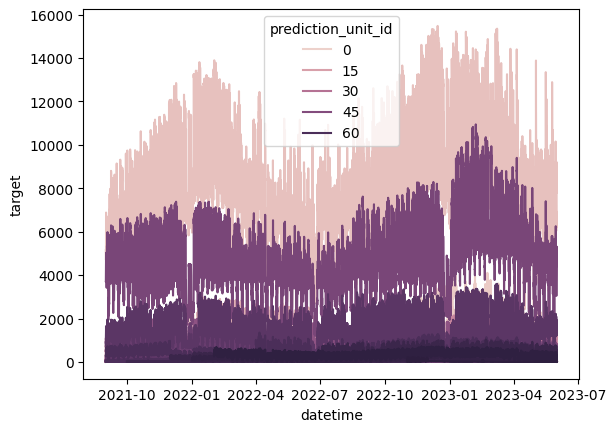

In [12]:
sns.lineplot(data.train[data.train.is_consumption == 1], x='datetime', y='target', hue='prediction_unit_id')

<Axes: xlabel='datetime'>

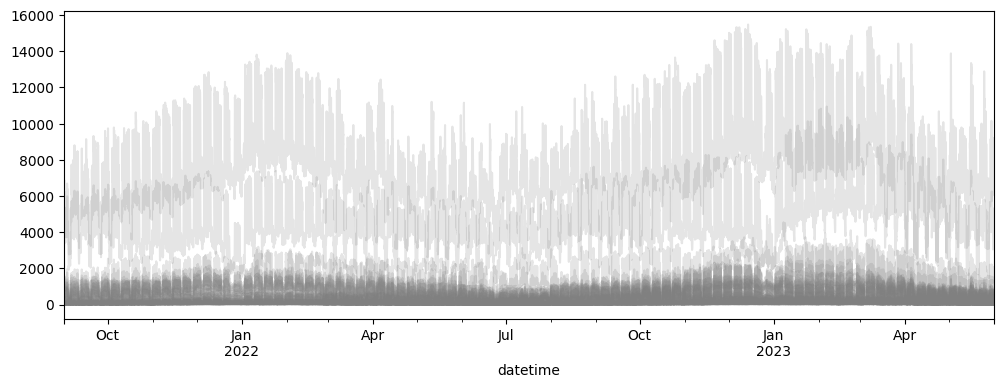

In [29]:
figsize(12, 4)
data.train[data.train.is_consumption == 1].pivot(index='datetime', columns='prediction_unit_id', values='target').plot(legend=False, alpha=0.2, color='gray')

<Axes: xlabel='datetime'>

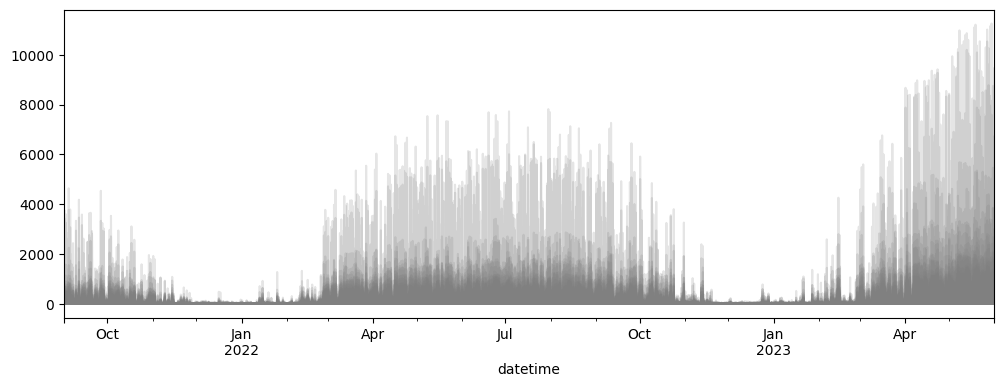

In [30]:
data.train[data.train.is_consumption == 0].pivot(index='datetime', columns='prediction_unit_id', values='target').plot(legend=False, alpha=0.2, color='gray')

Ok, great. We can see that there is strong annual seasonality, as well as other seasonal patterns. I'm sure that there will be weekly, as well as daily effects.

In fact, there are probably effects due to holidays as well.

In [56]:
trainData = pl.from_dataframe(data.train)

In [64]:
# add weekday column
trainData = trainData.with_columns(pl.col('datetime').dt.weekday().alias('weekday'))

<Axes: >

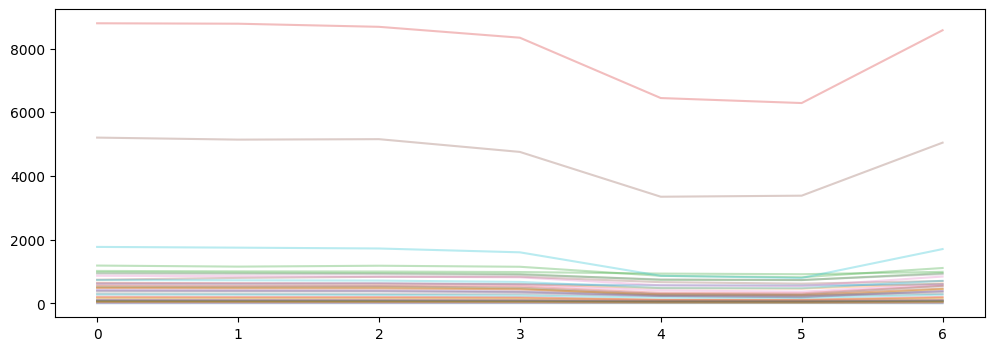

In [80]:
weekdayEffect = trainData.filter( (pl.col('is_consumption') == 1) & (pl.col('is_business') == 1)
                ).pivot(index='weekday', columns='prediction_unit_id', values='target', aggregate_function='mean')
weekdayEffect.to_pandas().plot(legend=False, alpha=0.3)

<Axes: >

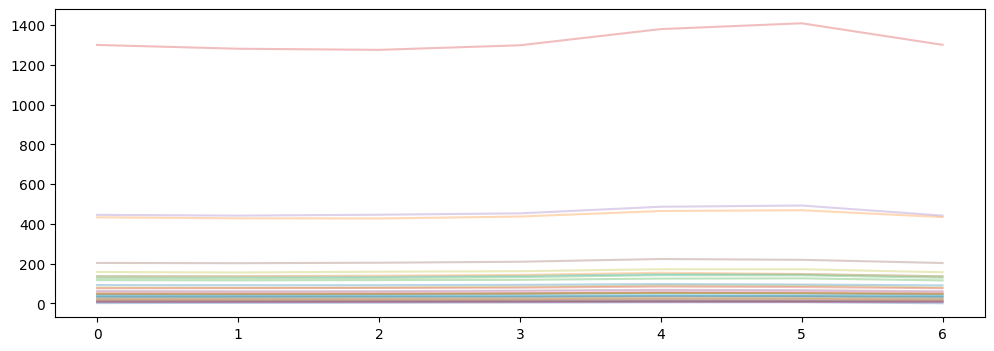

In [81]:
weekdayEffect = trainData.filter( (pl.col('is_consumption') == 1) & (pl.col('is_business') == 0)
                ).pivot(index='weekday', columns='prediction_unit_id', values='target', aggregate_function='mean')
weekdayEffect.to_pandas().plot(legend=False, alpha=0.3)

Indeed, there is an effect of weekday here too. It makes sense that buisnesses would consume less on weekends, while homes consume more. That said, the days don't quite make sense: 4-Thursday, 5-Friday.

#### Can we explain the daily and weekly cycles in terms of the fractions of the max?

The individual prediction units seem to have a shared cycle, but around their own baseline

To what extent does the variance in production correlated with the mean production?

In [75]:
workingTrain = data.train.copy()
workingTrain['date'] = workingTrain.datetime.dt.date
workingTrain['time'] = workingTrain.datetime.dt.time
workingTrain['year'] = workingTrain.datetime.dt.year
workingTrain.drop(columns=['county', 'is_business', 'product_type', 'data_block_id', 'row_id', 'datetime'], inplace=True)

In [92]:
dailyStats = workingTrain.groupby([ 'prediction_unit_id', 'is_consumption', 'date']).agg(
                                                                            daily_min=('target', 'min'),
                                                                            daily_max=('target', 'max'),
                                                                            daily_mean=('target', 'mean'),
                                                                            daily_std=('target', 'std')
                                                                           ).reset_index()

<Axes: title={'center': 'Mean Production'}, xlabel='date'>

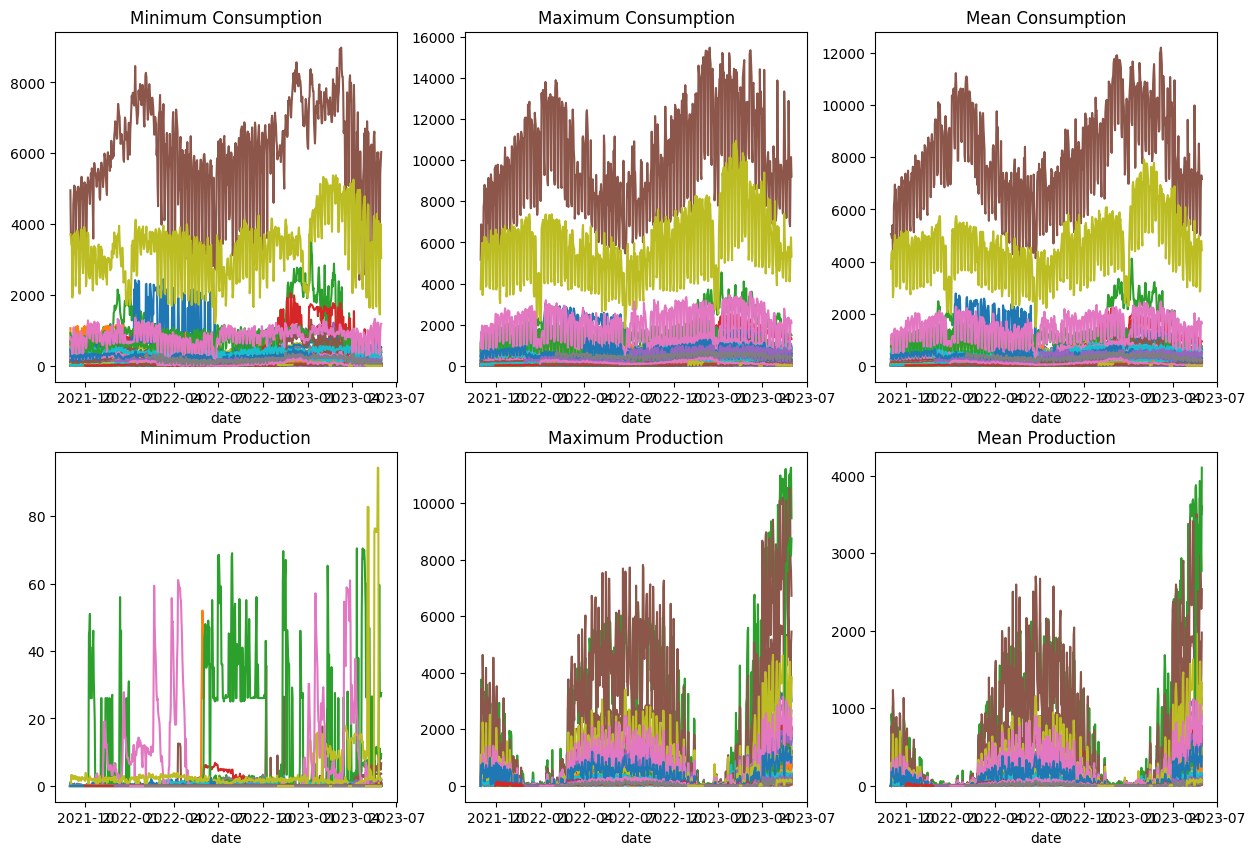

In [126]:
figsize(15, 10)
fig, axes = plt.subplots(2,3)

axes[0, 0].set_title('Minimum Consumption')
axes[0, 1].set_title('Maximum Consumption')
axes[0, 2].set_title('Mean Consumption')

dailyStats[ dailyStats.is_consumption == 1].pivot(index='date', columns='prediction_unit_id', values='daily_min').plot(legend=False, ax=axes[0, 0])
dailyStats[ dailyStats.is_consumption == 1].pivot(index='date', columns='prediction_unit_id', values='daily_max').plot(legend=False, ax=axes[0, 1])
dailyStats[ dailyStats.is_consumption == 1].pivot(index='date', columns='prediction_unit_id', values='daily_mean').plot(legend=False, ax=axes[0, 2])


axes[1, 0].set_title('Minimum Production')
axes[1, 1].set_title('Maximum Production')
axes[1, 2].set_title('Mean Production')

dailyStats[ dailyStats.is_consumption == 0].pivot(index='date', columns='prediction_unit_id', values='daily_min').plot(legend=False, ax=axes[1, 0])
dailyStats[ dailyStats.is_consumption == 0].pivot(index='date', columns='prediction_unit_id', values='daily_max').plot(legend=False, ax=axes[1, 1])
dailyStats[ dailyStats.is_consumption == 0].pivot(index='date', columns='prediction_unit_id', values='daily_mean').plot(legend=False, ax=axes[1, 2])

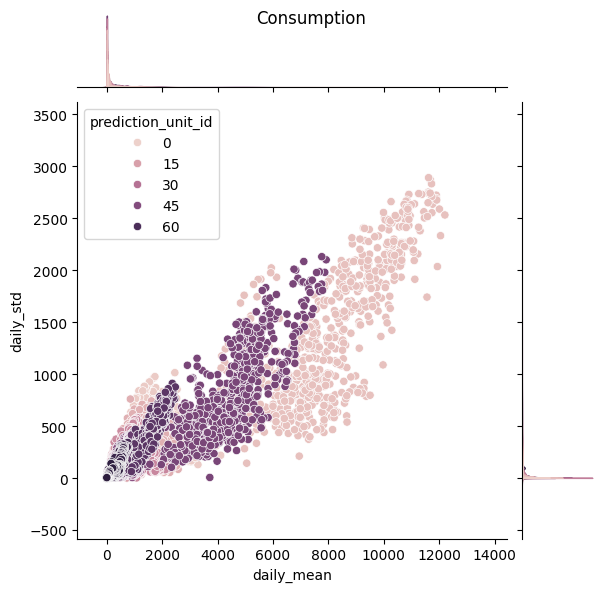

In [164]:
figsize(3,3)

ax = sns.jointplot(data=dailyStats[ dailyStats.is_consumption == 1], x='daily_mean', y='daily_std', hue='prediction_unit_id')
_=ax.fig.suptitle('Consumption')

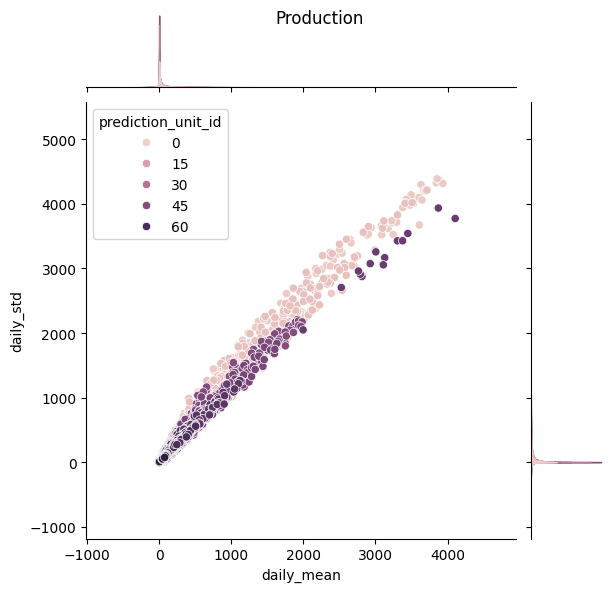

In [165]:
ax = sns.jointplot(data=dailyStats[ (dailyStats.is_consumption == 0)], x='daily_mean', y='daily_std', hue='prediction_unit_id')
_=ax.fig.suptitle('Production')

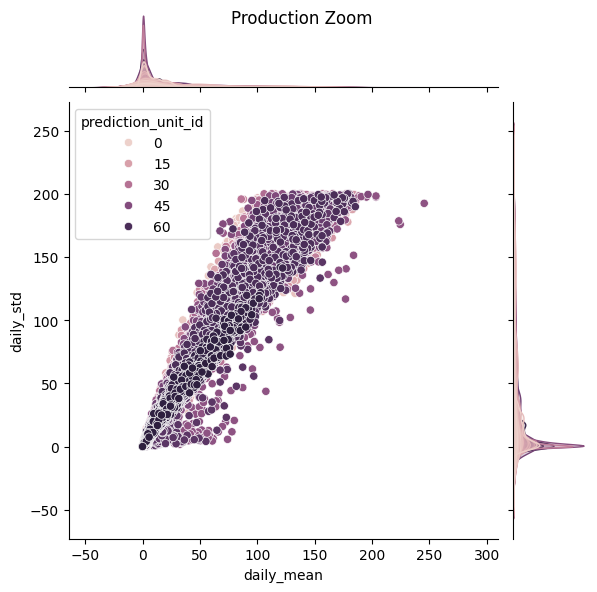

In [166]:
ax = sns.jointplot(data=dailyStats[ (dailyStats.is_consumption == 0) & (dailyStats.daily_std<200)], x='daily_mean', y='daily_std', hue='prediction_unit_id')
_=ax.fig.suptitle('Production Zoom')

Here we see that for both consumption and production, the daily average correlates quite well with the daily standard deviation across days. This is particularly strong for production, even when zooming in on the bulk of the data.

Not a terribly surprising result, since it is essentially a function of installed capacity. However, this does indicated that:
- we should model variation within days _multiplicatively_

__Follow-up__: 
On another note, there is structure in both of these relative to the prediction_unit_id, indicating dependence of the relationship on EIC and is_buisness, maybe even county

In [200]:
unitStats = dailyStats.groupby(['prediction_unit_id', 'is_consumption']).agg(std_of_daily_mean=('daily_mean','std'),
                                             mean_of_daily_mean=('daily_mean', 'mean'),
                                             std_of_daily_max=('daily_max','std'),
                                             mean_of_daily_max=('daily_max','mean')
                                            ).reset_index()



<Axes: title={'center': 'Unit Production'}, xlabel='mean_of_daily_mean', ylabel='std_of_daily_mean'>

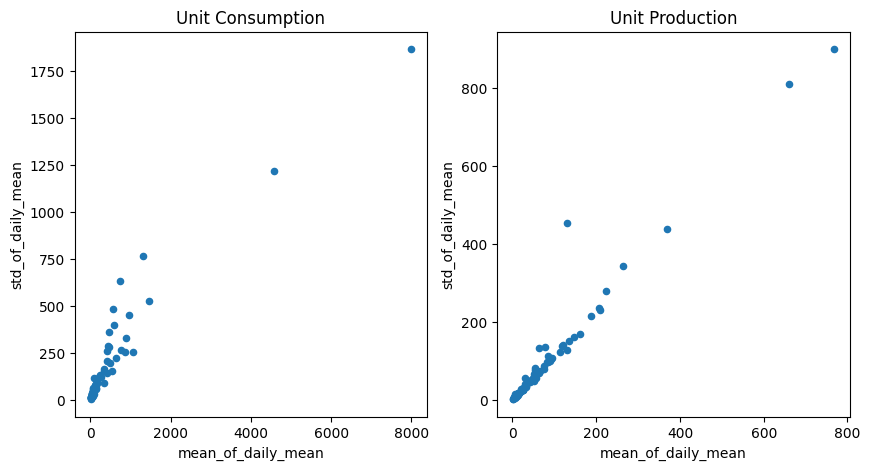

In [201]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)
axes[0].set_title('Unit Consumption')
unitStats[unitStats.is_consumption == 1].plot(x='mean_of_daily_mean', y='std_of_daily_mean', legend=False, kind='scatter', ax=axes[0])

axes[1].set_title('Unit Production')
unitStats[unitStats.is_consumption == 0].plot(x='mean_of_daily_mean', y='std_of_daily_mean', legend=False, kind='scatter', ax=axes[1])

<Axes: title={'center': 'Unit Production - max'}, xlabel='mean_of_daily_max', ylabel='std_of_daily_max'>

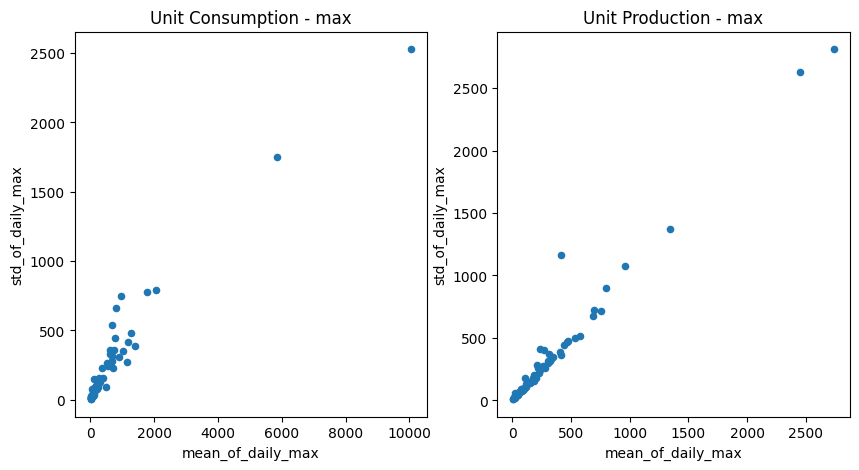

In [203]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)
axes[0].set_title('Unit Consumption - max')
unitStats[unitStats.is_consumption == 1].plot(x='mean_of_daily_max', y='std_of_daily_max', legend=False, kind='scatter', ax=axes[0])

axes[1].set_title('Unit Production - max')
unitStats[unitStats.is_consumption == 0].plot(x='mean_of_daily_max', y='std_of_daily_max', legend=False, kind='scatter', ax=axes[1])

Here we see that a similar effect shows up in variation across days of daily statistics. That is to say, 
- the day-to-day variation should be modeled _multiplicitively_ as well

The same holds for day of the week variation as well.

It seems reasonable that the maximum possible output is predictable by the type of installation

In [45]:
workingTrain = data.train.copy()
workingTrain['date'] = workingTrain.datetime.dt.date

maximumSeen = workingTrain.groupby(
                                ['county', 'is_business', 'product_type', 'is_consumption', 'date', 'prediction_unit_id']
                            ).agg(maxOutput=('target', 'max')).reset_index()

unitStatistics = maximumSeen.merge(data.clients, on=['county', 'is_business', 'product_type', 'date'])

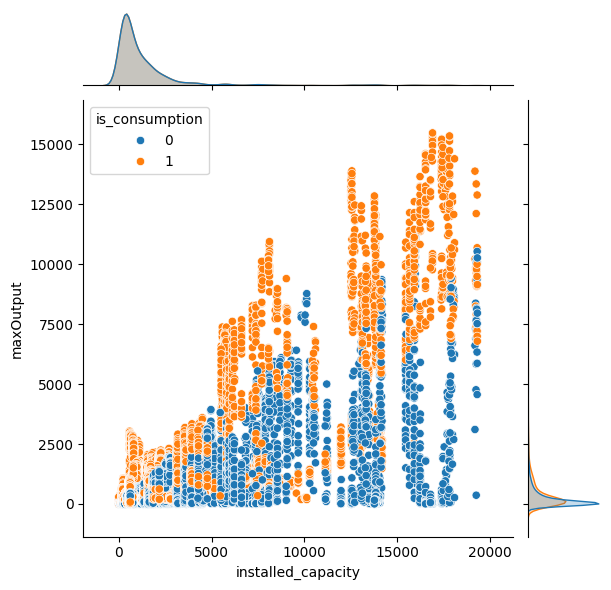

In [46]:
sns.jointplot(data=unitStatistics, x='installed_capacity', y='maxOutput', hue='is_consumption')

Ok, at present, this seems to be swamped by the seasonality in the daily data. Still a reasonable __follow-up__


In [47]:
unitStatistics['prop-to-capacity'] = unitStatistics.maxOutput / unitStatistics.installed_capacity

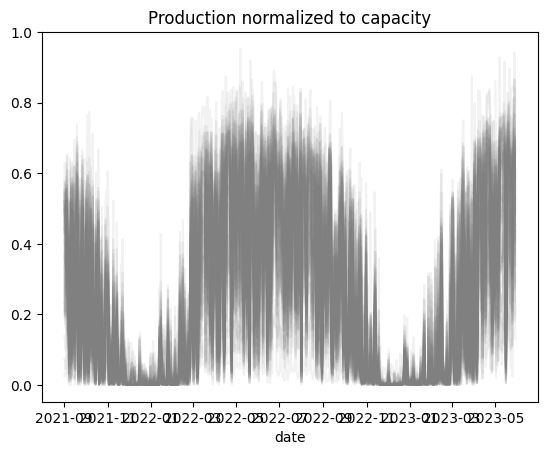

In [70]:
ax = unitStatistics[unitStatistics.is_consumption==0].pivot(
                                                    index='date',
                                                    columns=['prediction_unit_id', 'is_consumption'],
                                                    values='prop-to-capacity'
                                                    ).plot(legend=False, alpha=0.1, color='grey')
_=ax.set_title('Production normalized to capacity')

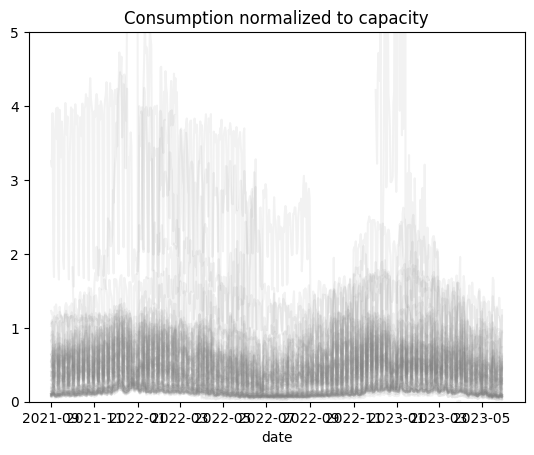

In [73]:
ax = unitStatistics[unitStatistics.is_consumption==1].pivot(
                                                    index='date',
                                                    columns=['prediction_unit_id', 'is_consumption'],
                                                    values='prop-to-capacity'
                                                    ).plot(legend=False, alpha=0.1, color='grey')
_=ax.set_title('Consumption normalized to capacity')
_=ax.set_ylim([0, 5])

Ok. Normalizing the production to installed capacity is really good for tightning the curves together. This is not the case to consumption.
It also works for detrending the production to some extent.

Q: Does production still vary fold wise?

<Axes: xlabel='capacity_normalized_mean', ylabel='capacity_normalized_std'>

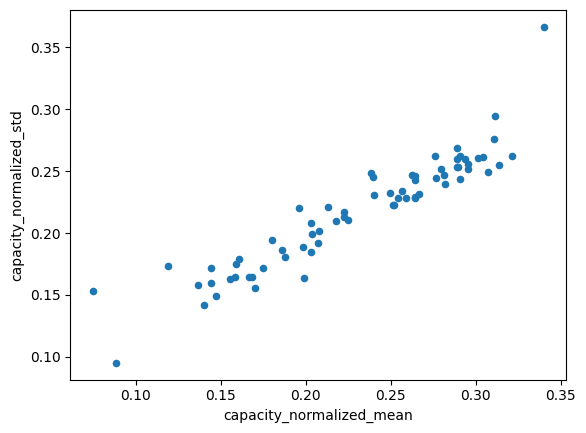

In [79]:
unitStatistics[unitStatistics.is_consumption==0].groupby('prediction_unit_id'
                                                ).agg(capacity_normalized_mean=('prop-to-capacity', 'mean'),
                                                 capacity_normalized_std=('prop-to-capacity', 'std') 
                                                ).plot(x='capacity_normalized_mean',y='capacity_normalized_std', kind='scatter')

Ok. A multiplicative model of the fluctuations is still reasonable.

## Weather

Honestly, my first question is about the timezones that the dates are given in these datesets?

__Ans:__ the data description has been updated, stating that all times are 'EET/EEST'. What happens to DST offsets.

Another question is how the locations that we have forecasts / datapoints for relate to the couties that we are predicting?

__Ans:__ The dataset has been updated, providing counties for weather stations. However, many of them are located in bodies of water.

At some level, I think this is the wrong question to ask a priori because the weather patterns themselves may vary differently between different locations. Instead, we should be asking how the weather data covaries with different locations.


In [2]:
# 12/15 lesson: don't write libraries for initial data exploration
import datetime 

trainDataLocation = '../data/train/'
weather_forecast = pd.read_csv(trainDataLocation+'forecast_weather.csv')
weather_historical = pd.read_csv(trainDataLocation+'historical_weather.csv')

weather_historical['datetime'] = pd.to_datetime(weather_historical['datetime'])
weather_historical = pl.from_pandas(weather_historical)

weather_forecast['origin_datetime'] = pd.to_datetime(weather_forecast['origin_datetime'])
weather_forecast['forecast_datetime'] = pd.to_datetime(weather_forecast['forecast_datetime'])
weather_forecast = pl.from_pandas(weather_forecast)

### Checking for an offset around DST changes

In [9]:
weather_historical = weather_historical.with_columns( 
                         pl.col('datetime').dt.time().alias('time'),
                         (pl.col('datetime') + datetime.timedelta(hours=-1)).dt.time().alias('shifted_time')
                        )

before_dst = weather_historical.filter(
                    (pd.to_datetime('2021-10-31') -pl.col('datetime') < datetime.timedelta(days=29))
                    &(pd.to_datetime('2021-10-31') -pl.col('datetime') > datetime.timedelta(days=1))
                 ).group_by(['time', 'latitude', 'longitude']
                 ).agg(pl.col('direct_solar_radiation').mean(),
                       pl.col('temperature').mean()
                 )

after_dst = weather_historical.filter(
                    (pd.to_datetime('2021-10-31') -pl.col('datetime') > datetime.timedelta(days=-29))
                    &(pd.to_datetime('2021-10-31') -pl.col('datetime') < datetime.timedelta(days=-1))
                 ).group_by(['time', 'latitude', 'longitude']
                 ).agg(pl.col('direct_solar_radiation').mean(),
                       pl.col('temperature').mean()
                 )


before_neg_ctl = weather_historical.filter(
                    (pd.to_datetime('2021-09-30') -pl.col('datetime') < datetime.timedelta(days=29))
                    &(pd.to_datetime('2021-09-30') -pl.col('datetime') > datetime.timedelta(days=1))
                 ).group_by(['time', 'latitude', 'longitude']
                 ).agg(pl.col('direct_solar_radiation').mean(),
                       pl.col('temperature').mean()
                 )

after_neg_ctl = weather_historical.filter(
                    (pd.to_datetime('2021-09-30') -pl.col('datetime') > datetime.timedelta(days=-29))
                    &(pd.to_datetime('2021-09-30') -pl.col('datetime') < datetime.timedelta(days=-1))
                 ).group_by(['time', 'latitude', 'longitude']
                 ).agg(pl.col('direct_solar_radiation').mean(),
                       pl.col('temperature').mean()
                 )


dst_pos_ctl = weather_historical.with_columns(pl.col('shifted_time').alias('time')).filter(
                    (pd.to_datetime('2021-10-31') -pl.col('datetime') < datetime.timedelta(days=29))
                    &(pd.to_datetime('2021-10-31') -pl.col('datetime') > datetime.timedelta(days=1))
                 ).group_by(['time', 'latitude', 'longitude']
                 ).agg(pl.col('direct_solar_radiation').mean(),
                       pl.col('temperature').mean()
                 )

Examining the changes in temperature and radiation data around daylight savings time

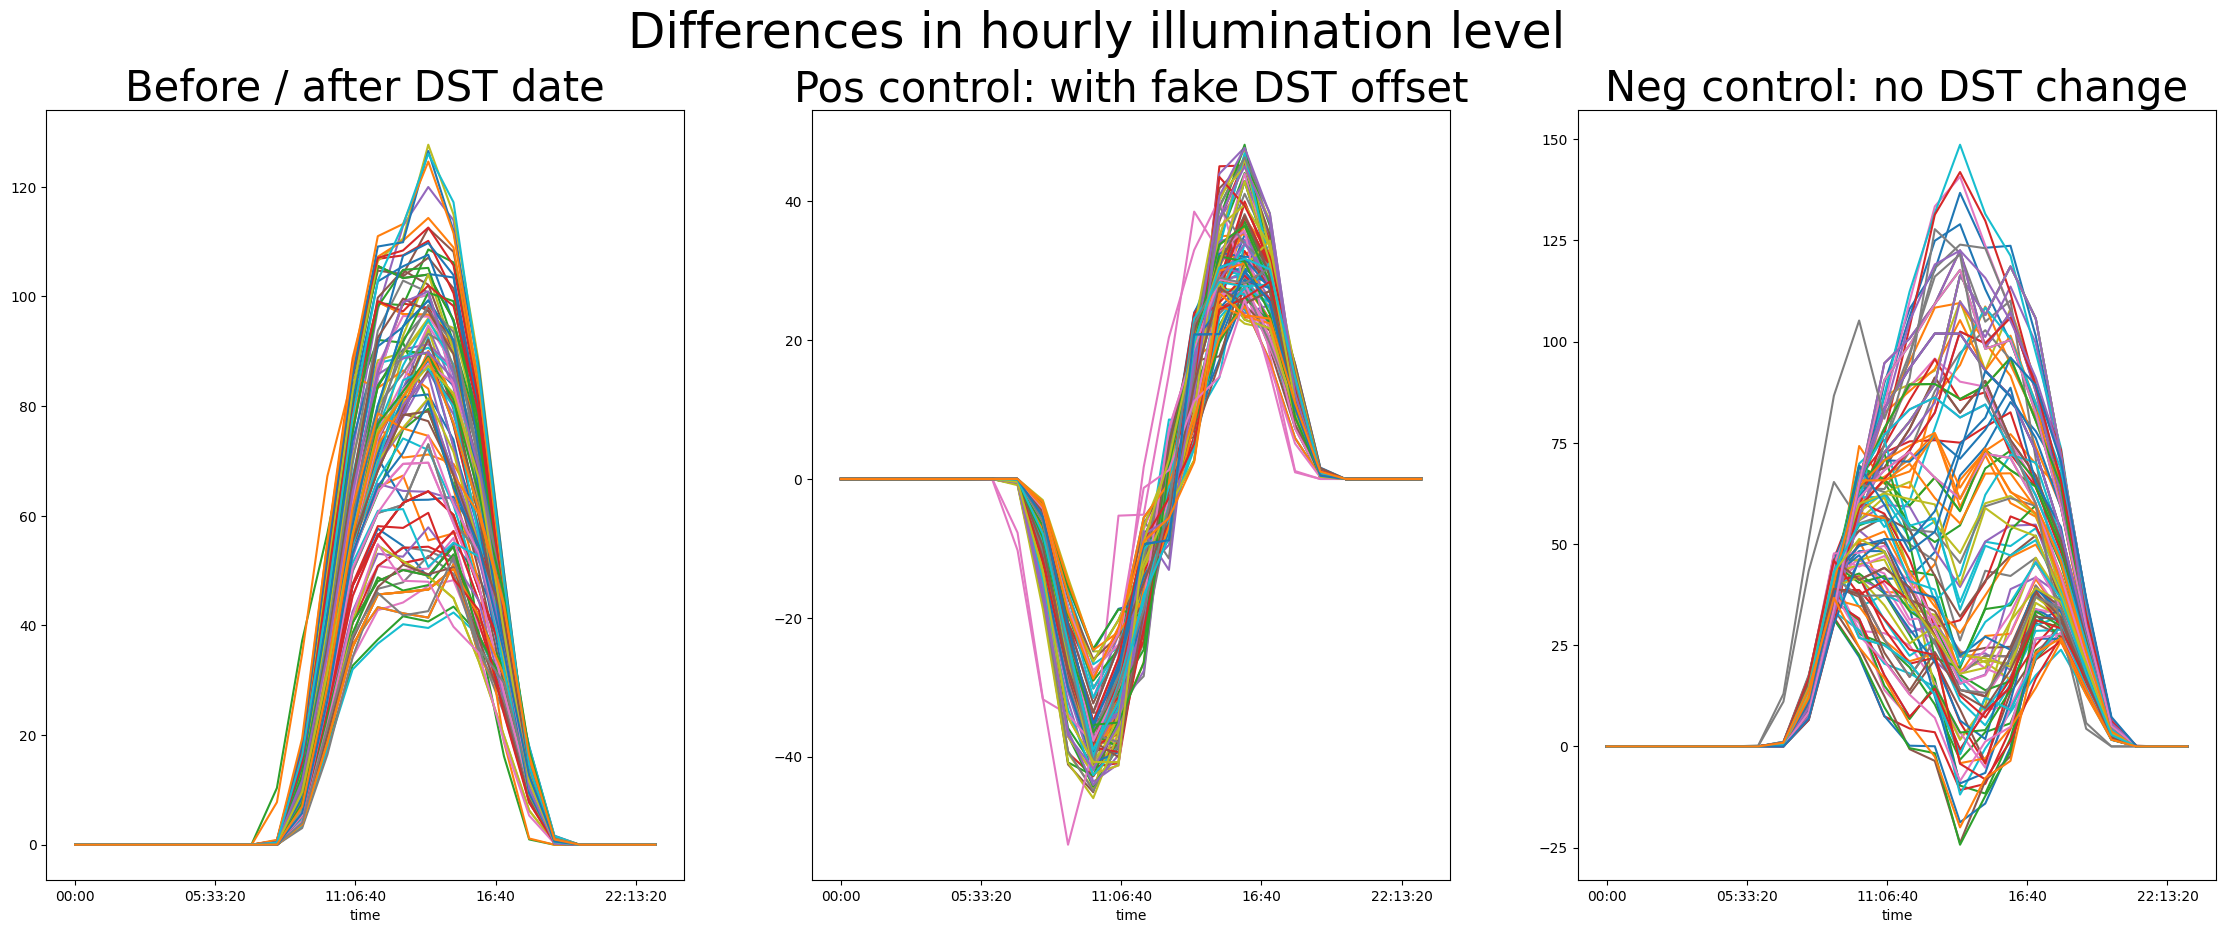

In [10]:
figsize(28,10)

fig, axes = plt.subplots(1,3)
plt.suptitle('Differences in hourly illumination level', fontsize=35)

before_dst.join( after_dst, on=['time', 'latitude', 'longitude'], suffix='_post' 
               ).with_columns( (pl.col('temperature') - pl.col('temperature_post')).alias('temperature_diff'),
                               (pl.col('direct_solar_radiation') -pl.col('direct_solar_radiation_post')).alias('radiation_diff')
               ).to_pandas(
               ).pivot(index='time', columns=['latitude', 'longitude'], values=['temperature_diff', 'radiation_diff']
               )['radiation_diff'].plot(legend=False, ax=axes[0])
axes[0].set_title('Before / after DST date', fontsize=30)

before_dst.join( dst_pos_ctl, on=['time', 'latitude', 'longitude'], suffix='_post' 
               ).with_columns( (pl.col('temperature') - pl.col('temperature_post')).alias('temperature_diff'),
                               (pl.col('direct_solar_radiation') -pl.col('direct_solar_radiation_post')).alias('radiation_diff')
               ).to_pandas(
               ).pivot(index='time', columns=['latitude', 'longitude'], values=['temperature_diff', 'radiation_diff']
               )['radiation_diff'].plot(legend=False, ax=axes[1])
axes[1].set_title('Pos control: with fake DST offset', fontsize=30)

before_neg_ctl.join( after_neg_ctl, on=['time', 'latitude', 'longitude'], suffix='_post' 
               ).with_columns( (pl.col('temperature') - pl.col('temperature_post')).alias('temperature_diff'),
                               (pl.col('direct_solar_radiation') -pl.col('direct_solar_radiation_post')).alias('radiation_diff')
               ).to_pandas(
               ).pivot(index='time', columns=['latitude', 'longitude'], values=['temperature_diff', 'radiation_diff']
               )['radiation_diff'].plot(legend=False, ax=axes[2])
_=axes[2].set_title('Neg control: no DST change', fontsize=30)

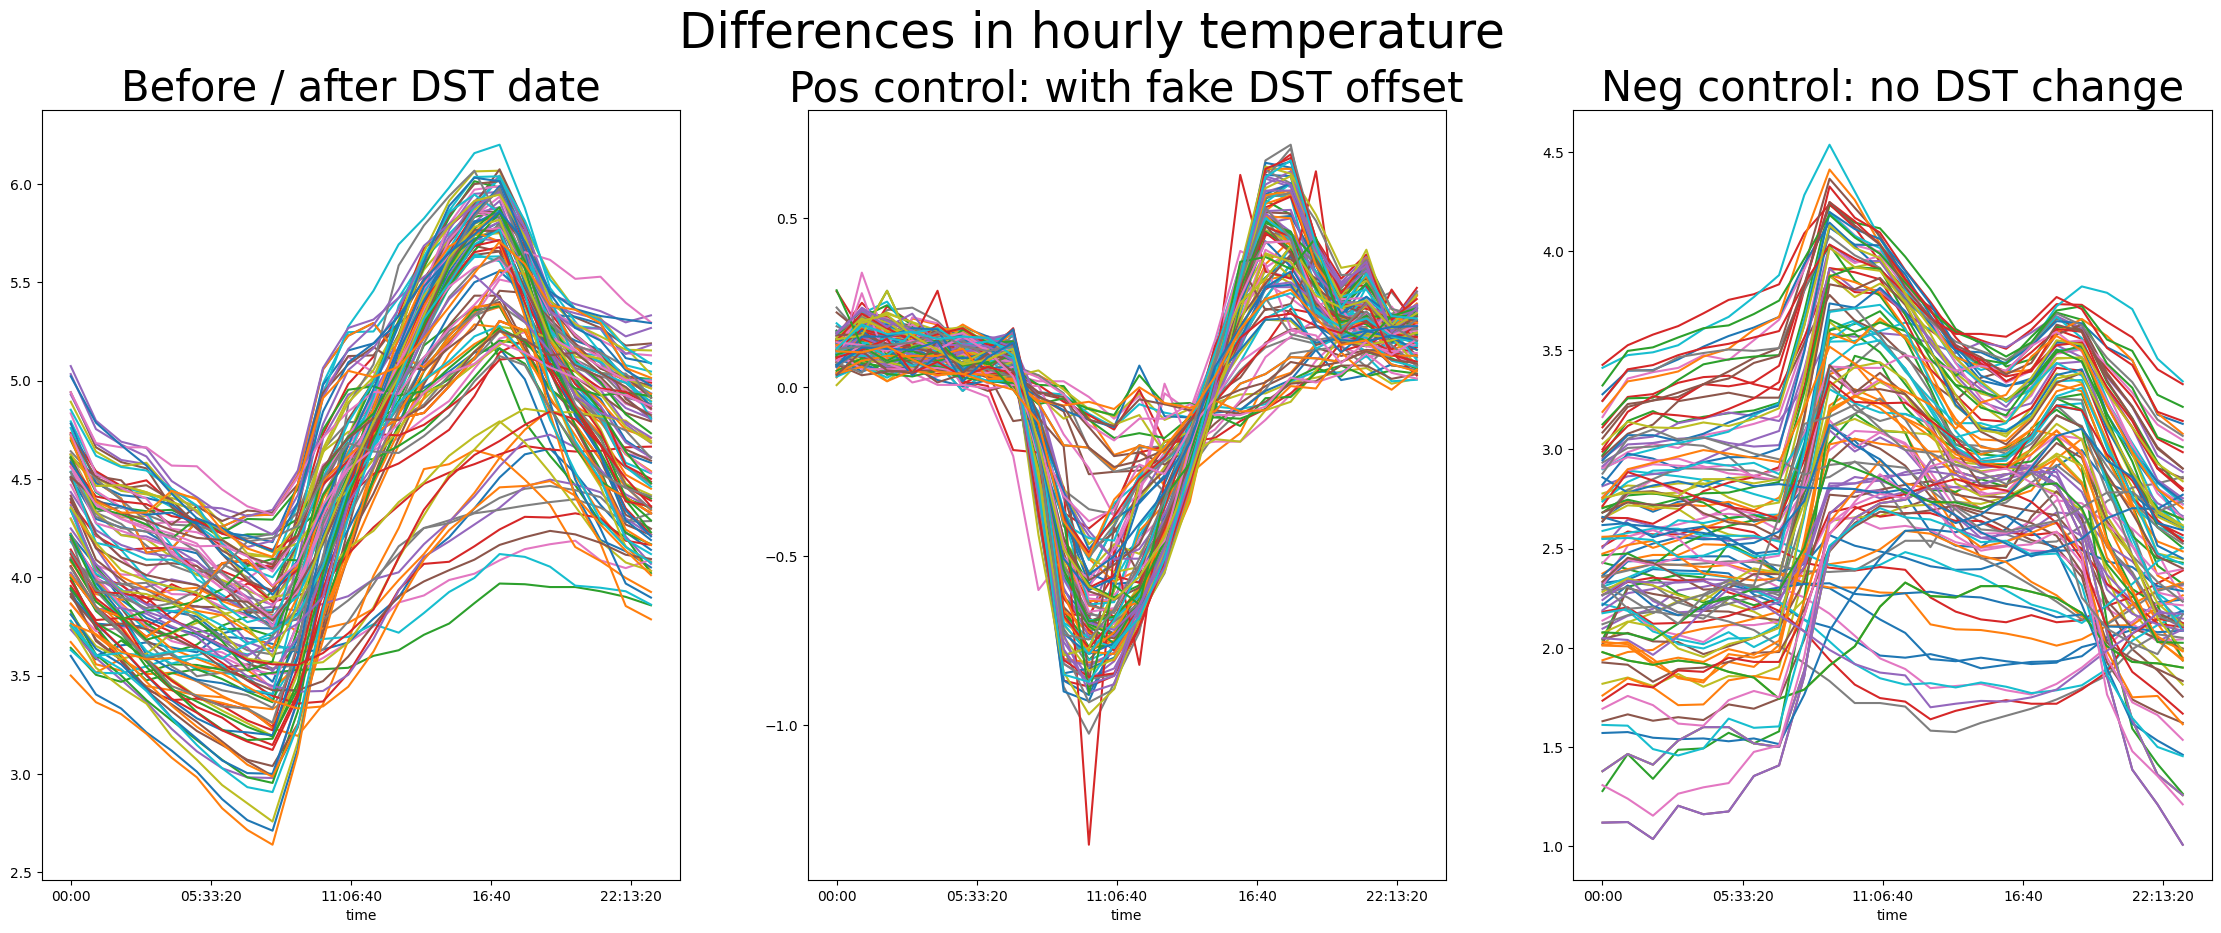

In [11]:
fig, axes = plt.subplots(1,3)
plt.suptitle('Differences in hourly temperature', fontsize=35)

before_dst.join( after_dst, on=['time', 'latitude', 'longitude'], suffix='_post' 
               ).with_columns( (pl.col('temperature') - pl.col('temperature_post')).alias('temperature_diff'),
                               (pl.col('direct_solar_radiation') -pl.col('direct_solar_radiation_post')).alias('radiation_diff')
               ).to_pandas(
               ).pivot(index='time', columns=['latitude', 'longitude'], values=['temperature_diff', 'radiation_diff']
               )['temperature_diff'].plot(legend=False, ax=axes[0])
axes[0].set_title('Before / after DST date', fontsize=30)

before_dst.join( dst_pos_ctl, on=['time', 'latitude', 'longitude'], suffix='_post' 
               ).with_columns( (pl.col('temperature') - pl.col('temperature_post')).alias('temperature_diff'),
                               (pl.col('direct_solar_radiation') -pl.col('direct_solar_radiation_post')).alias('radiation_diff')
               ).to_pandas(
               ).pivot(index='time', columns=['latitude', 'longitude'], values=['temperature_diff', 'radiation_diff']
               )['temperature_diff'].plot(legend=False, ax=axes[1])
axes[1].set_title('Pos control: with fake DST offset', fontsize=30)

before_neg_ctl.join( after_neg_ctl, on=['time', 'latitude', 'longitude'], suffix='_post' 
               ).with_columns( (pl.col('temperature') - pl.col('temperature_post')).alias('temperature_diff'),
                               (pl.col('direct_solar_radiation') -pl.col('direct_solar_radiation_post')).alias('radiation_diff')
               ).to_pandas(
               ).pivot(index='time', columns=['latitude', 'longitude'], values=['temperature_diff', 'radiation_diff']
               )['temperature_diff'].plot(legend=False, ax=axes[2])
_=axes[2].set_title('Neg control: no DST change', fontsize=30)

I think this is a bit of a rabbit hole that I want to avoid. Just by a look at the plots, it looks like the before / after daylight savings split is a sum of the positive control (time change effects), and the negative control (day-light effects)

One more piece of evidence (below):

In [166]:
weather_forecast = weather_forecast.with_columns(
                                pl.col('origin_datetime').dt.time().alias('time'),
                                pl.col('origin_datetime').dt.date().alias('date')
                        )
weather_forecast['time'].unique()

shape: (2,)
Series: 'time' [time]
[
	01:00:00
	02:00:00
]

In [171]:
weather_forecast.to_pandas()[ weather_forecast.to_pandas().time == pd.to_datetime('01:00:00').time() 
                            ][['origin_datetime', 'hours_ahead', 'forecast_datetime']].tail()

origin_datetime  hours_ahead   forecast_datetime
3075067 2023-03-26 01:00:00           48 2023-03-28 02:00:00
3075068 2023-03-26 01:00:00           48 2023-03-28 02:00:00
3075069 2023-03-26 01:00:00           48 2023-03-28 02:00:00
3075070 2023-03-26 01:00:00           48 2023-03-28 02:00:00
3075071 2023-03-26 01:00:00           48 2023-03-28 02:00:00

The predictions are made only at 1:00 and 2:00, seemingly due to the DST switch. At the last 1:00am predictions, 48 hours ahead is 2:00am. This indicates surely that the times are in fact local.

In [218]:
weather_forecast.filter( pl.col('forecast_datetime') == pd.to_datetime('2023-03-26 03:00:00'))

shape: (0, 20)
┌──────────┬───────────┬────────────────┬─────────────┬───┬──────────┬───────────────┬──────┬──────┐
│ latitude ┆ longitude ┆ origin_datetim ┆ hours_ahead ┆ … ┆ snowfall ┆ total_precipi ┆ time ┆ date │
│ ---      ┆ ---       ┆ e              ┆ ---         ┆   ┆ ---      ┆ tation        ┆ ---  ┆ ---  │
│ f64      ┆ f64       ┆ ---            ┆ i64         ┆   ┆ f64      ┆ ---           ┆ time ┆ date │
│          ┆           ┆ datetime[ns]   ┆             ┆   ┆          ┆ f64           ┆      ┆      │
╞══════════╪═══════════╪════════════════╪═════════════╪═══╪══════════╪═══════════════╪══════╪══════╡
└──────────┴───────────┴────────────────┴─────────────┴───┴──────────┴───────────────┴──────┴──────┘

### Comparing forecast and historical weather

In [33]:
# columns included
weather_historical = weather_historical.drop(['time', 'shifted_time'])

train_columns_historical = set(weather_historical.columns)
train_columns_forecasts = set(weather_forecast.columns)


In [35]:
train_columns_historical.intersection( train_columns_forecasts)

{'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 'data_block_id',
 'dewpoint',
 'direct_solar_radiation',
 'latitude',
 'longitude',
 'snowfall',
 'temperature'}

In [36]:
train_columns_historical.difference(train_columns_forecasts)

{'datetime',
 'diffuse_radiation',
 'rain',
 'shortwave_radiation',
 'surface_pressure',
 'winddirection_10m',
 'windspeed_10m'}

In [37]:
train_columns_forecasts.difference(train_columns_historical)

{'10_metre_u_wind_component',
 '10_metre_v_wind_component',
 'forecast_datetime',
 'hours_ahead',
 'origin_datetime',
 'surface_solar_radiation_downwards',
 'total_precipitation'}

#### Immediate observations:
1. 10m wind is written in different ways
2. total_precipitation vs rain
3. radiation

Additionally, `snowfall` has different units, and `cloudcover` is at different altitudes.

In the end, we want to
- use forecast data to _predict_ actual data
- regress actual data against production / consumption 

#### How good are the forecasts?

In [174]:
column_name = 'temperature'
differences = weather_historical.with_columns(
                            #(pl.col('datetime') + datetime.timedelta(hours=1)).cast(pl.Datetime('ns'))
                        ).join( weather_forecast,
                                left_on=['latitude', 'longitude', 'datetime'],
                                right_on=['latitude', 'longitude', 'forecast_datetime'],
                                suffix='_forecast'
                        ).with_columns( 
                            (pl.col(column_name) - pl.col( column_name + '_forecast')).alias('difference')
                        ).select(
                            ['latitude', 'longitude', 'datetime', 'hours_ahead', 'difference', ]
                        )
    

<Axes: xlabel='hours_ahead'>

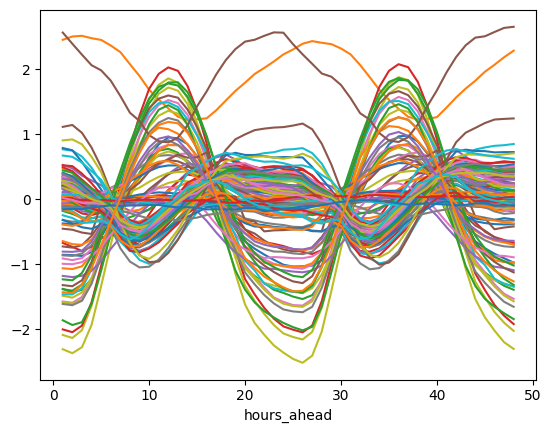

In [175]:
differences.group_by(['latitude', 'longitude', 'hours_ahead']
              ).agg(pl.col('difference').mean()
              ).to_pandas(
              ).pivot(index='hours_ahead', columns=['latitude', 'longitude'], values='difference'
              ).plot(legend=False)

What on earth is happening here? It seems like the predictions deviate systematically from the measured data. What's more, this deviation depends on the amount of time in advance the prediction is being made. The predictions are always made at the same time, UTC, so this could be explained if the predictions are systematically off in a _time-dependent way_.

One explaination for this behavior is that the deviation is due to local conditions of the weather stations: the micro-climate of their locations impact their temperature fluctuations through the day. 

<Axes: xlabel='datetime'>

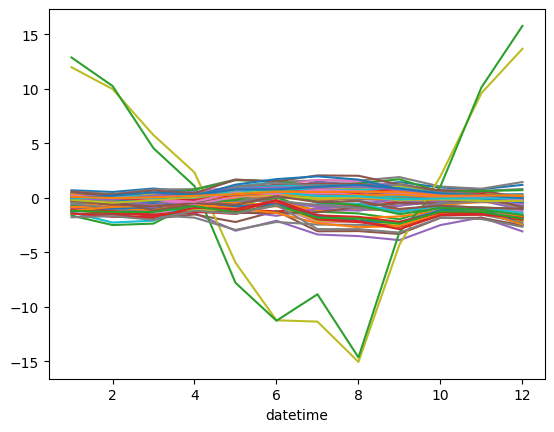

In [207]:
fig, ax =plt.subplots(1,1)
differences.with_columns( pl.col('datetime').dt.month()
         ).group_by(['latitude', 'longitude', 'datetime', 'hours_ahead']
         ).agg(pl.col('difference').mean()
         ).filter(pl.col('hours_ahead') == 1
         ).to_pandas(
         ).pivot(index='datetime', columns=['latitude', 'longitude'], values='difference'
         ).plot(legend=False, ax=ax)
#ax.set_ylim([-4,4])

Some of them even have month-dependencies in their biases. (note the axis scale, even the small fluctuations are pretty sizable)

All of this raises the question: Why does this matter?

Do we even need to try to relate the forecast and historical features?

Neither the forecast nor the monitoring stations are for exactly the points where the solar is installed. Future forecasts and previous hisory are both available for each forecasting. Maybe the thing to do (at least initially) is to not relate them at all... they are really just different features for the predictions. This is particularly true if we are using all weather data for all of the county locations.
